In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from ppo import PPO
from config_utils import get_config
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import utils

In [3]:
from envs import env_carracing_simple
env = env_carracing_simple.CarRacingSimple()

In [4]:
# config = get_config("configs/config-2020_06_02.json")
config = get_config("configs/config-2020_06_07-resnet18.json")

# config.actor_critic["actor"]["learning_rate"] = 0.0001
# config.actor_critic["critic"]["learning_rate"] = 0.0001
print(config)

num_epochs = 1500
# num_epochs = 100
# num_epochs = 2
minibatch_size = 1

if config.has_training:
    num_epochs = config.training.get("num_epochs", num_epochs)
    minibatch_size = config.training.get("minibatch_size", minibatch_size)

{'ppo_hyperparameters': {'epsilon': 0.2, 'discount_factor': 0.9, 'delta': 0.95, 'actor_critic': {'actor': {'learning_rate': 0.0001}, 'critic': {'learning_rate': 0.0001, 'alpha': 0.75}}}, 'training': {'num_epochs': 1500}}


In [5]:
checkpoint_interval = 10
experiment_dir = "experiments/2020_06_07-01-resnet18"

os.makedirs(experiment_dir, exist_ok=True)

In [6]:
from actor_critics import carracing_resnet_18_ac as ac
actor = ac.Actor(env)
critic = ac.Critic(env)

ppo = PPO(
    env,
    config=config,
    actor=actor,
    critic=critic,
    no_cuda=False
)

In [7]:
loss_vals = []
pbar = tqdm(range(num_epochs))
for i in pbar:
    step_loss_vals = ppo.step()
    loss_vals.append(sum(step_loss_vals) / len(step_loss_vals))
    pbar.set_description("Loss = {:.6f}".format(loss_vals[-1]))
    
    if i%checkpoint_interval == 0:
        utils.save_ppo_checkpoint(
            exp_dir = experiment_dir,
            epoch = i,
            loss = loss_vals[-1],
            ppo = ppo,
        )

3..1433 -> 290-tiles track
Track generation: 1072..1344 -> 272-tiles track
Track generation: 1066..1344 -> 278-tiles track
Track generation: 1021..1286 -> 265-tiles track
Track generation: 1201..1511 -> 310-tiles track
Track generation: 1354..1695 -> 341-tiles track
Track generation: 1171..1468 -> 297-tiles track
Track generation: 1168..1464 -> 296-tiles track
Track generation: 1097..1385 -> 288-tiles track
Track generation: 1160..1462 -> 302-tiles track
Track generation: 1131..1432 -> 301-tiles track
Track generation: 1046..1314 -> 268-tiles track
retry to generate track (normal if there are not many instances of this message)
Track generation: 1118..1410 -> 292-tiles track
Track generation: 1112..1394 -> 282-tiles track
Track generation: 1058..1335 -> 277-tiles track
Track generation: 1220..1529 -> 309-tiles track
Track generation: 1147..1444 -> 297-tiles track
Track generation: 1048..1324 -> 276-tiles track
Track generation: 1180..1479 -> 299-tiles track
Track generation: 1084..1359

In [8]:
# save final checkpoint
utils.save_ppo_checkpoint(
    exp_dir = experiment_dir,
    epoch = num_epochs,
    loss = loss_vals[-1],
    ppo = ppo
)

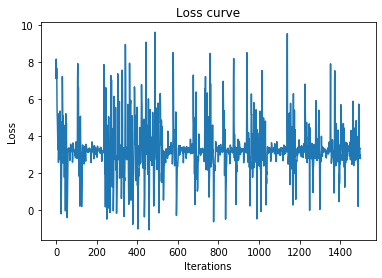

In [13]:
# save loss values
loss_dir = os.path.join(experiment_dir, "loss")
utils.save_loss(loss_dir=loss_dir, loss_vals=loss_vals, save_default_plot=True)

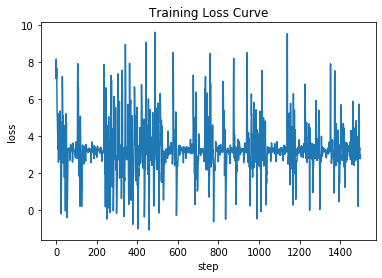

In [14]:
plt.plot(loss_vals)
plt.xlabel("step")
plt.ylabel("loss")
plt.title("Training Loss Curve")
plt.show()

In [15]:
import torch
from torch.autograd import Variable

In [23]:
#env_new = wrappers.Monitor(env, './video/', force = True)
times = 0
env_new = env
observation = env_new.reset()
# observation = Variable(torch.from_numpy(observation), requires_grad=False).to(ppo.torch_device)
observation = torch.unsqueeze(
    torch.from_numpy(observation.copy()),
    0
).to(ppo.torch_device)

reward_sum = 0.0
reward_list = []

# total_iterations = 100
total_iterations = 200
for _ in range(total_iterations):
    env_new.render()
    action = torch.argmax(ppo.pi(observation.float()))
    observation, reward, done, info = env_new.step(action.cpu().detach().numpy())
    
    reward_sum += reward
    reward_list.append(reward)
    # observation = Variable(torch.from_numpy(observation), requires_grad=False).to(ppo.torch_device)
    observation = torch.unsqueeze(
        torch.from_numpy(observation.copy()),
        0
    ).to(ppo.torch_device)
    if not done:
        times += 1
        
print(times)
env_new.close()

Track generation: 1149..1445 -> 296-tiles track
184


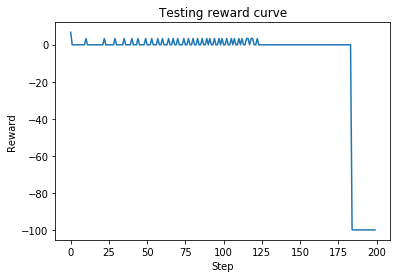

In [25]:
plt.plot(reward_list)
plt.title("Testing reward curve")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.show()